# Fitbit Data Analysis

This notebook walks you through the tools you need in order to download and analyze your own fitbit data, including a very basic exporatory review of sleep endpoint data as a proof of concept. The data access and evaluation functions developed within this framework are used in the more detailed exploration in this repository:  Fitbit Sleep Disruption Analysis

contributors: [leaherb](https://github.com/leaherb), [MelissaSmith12](https://github.com/MelissaSmith12/), [nesreensada](https://github.com/nesreensada)

## Process Flow
1. Set up authorization for using the FitBit API.
2. Pull data from FitBit into a list of dictionaries ('activity_data') for a particular endpoint.
3. Prepare an endpoint data frame for analysis. 
4. Analyze.

### Alternative - use data in CSV file instead of connecting to FitBit
If you analyzing FitBit data stored in a CSV file:
1. Skip Steps 1, 2 and 3 in the process flow above 
2. Go to "3 Alternative" set of functions to read the CSV data and create the endpoint data frame structure. 
3. Continue with Step 4 to start your analysis. 

An example CSV file is in the repository: example_sleep.csv 

Note: These example files were generated from the data we obtained via the API. You may need to modify how the data is loaded if you are using csv files from the fitbit website.

In [2]:
from datetime import datetime
import json
import keyring
import requests

import fitbit
import gather_keys_oauth2 as Oauth2
import pandas as pd 
from pprint import pprint
import matplotlib.pyplot as plt

# 1 - Set up authorization for using the FitBit API

First we have to set up authorization for the FitBit API. These instructions show you how to set up Fitbit so that you can connect to their api. 

https://towardsdatascience.com/collect-your-own-fitbit-data-with-python-ff145fa10873

At the moment, the first chunk of the code in this notebook is copied directly from this post.


When the directions mention secrets and keys, you'll notice that the code has in this notebook has stored the key and secret using the keyring library. This library helps you manage your keys and IDs (so that if you share your code, you don't share your credentials!).

Here's a great link on how/why to use the keyring library.

https://alexwlchan.net/2016/11/you-should-use-keyring/

One last thing to note is that while we import the fitbit library, we're really only using it for authentication. In other words, we stop following the instruction after step two. Why is this? The fitbit python library calls the fitbit api in units of one day. And the fitbit api limits a single user's calls to 150 per hour, which means that if we used this library, we'd be limited to grabbing only 5 months of data at a time. 

Instead, we're going to create some functions that interact directly with the fitbit API so that we can grab a range of days' worth of data at a time.

To be clear, sometimes you might want to get a single day's worth of data (and there's some code that does exactly that at the bottom of this notebook, but for this analysis, I'm more interested in trends across days than within days.

In [3]:
CLIENT_ID = keyring.get_password("fitbit", "key")
CLIENT_SECRET = keyring.get_password("fitbit", "secret")

server = Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()
ACCESS_TOKEN = str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN = str(server.fitbit.client.session.token['refresh_token'])
auth2_client = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

[22/Jul/2018:10:24:18] ENGINE Listening for SIGTERM.
[22/Jul/2018:10:24:18] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[22/Jul/2018:10:24:18] ENGINE Set handler for console events.
[22/Jul/2018:10:24:18] ENGINE Started monitor thread 'Autoreloader'.
[22/Jul/2018:10:24:18] ENGINE Serving on http://127.0.0.1:8080
[22/Jul/2018:10:24:18] ENGINE Bus STARTED


127.0.0.1 - - [22/Jul/2018:10:24:20] "GET /?code=519fe2631e95cf7a14668514878ef340db2d47fd&state=LIr6XOGDFPMfVGjkiRGFtmJZja0Yyk HTTP/1.1" 200 122 "" "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36"
127.0.0.1 - - [22/Jul/2018:10:24:21] "GET /favicon.ico HTTP/1.1" 200 1406 "http://127.0.0.1:8080/?code=519fe2631e95cf7a14668514878ef340db2d47fd&state=LIr6XOGDFPMfVGjkiRGFtmJZja0Yyk" "Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36"


[22/Jul/2018:10:24:21] ENGINE Bus STOPPING
[22/Jul/2018:10:24:31] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[22/Jul/2018:10:24:31] ENGINE Stopped thread 'Autoreloader'.
[22/Jul/2018:10:24:31] ENGINE Removed handler for console events.
[22/Jul/2018:10:24:31] ENGINE Bus STOPPED
[22/Jul/2018:10:24:31] ENGINE Bus EXITING
[22/Jul/2018:10:24:31] ENGINE Bus EXITED
[22/Jul/2018:10:24:31] ENGINE Waiting for child threads to terminate...


Now we're authorized to pull data from the Fitbit API. If you've never interacted with an api before, that won't keep you from moving forward with this analysis. Here's the only pieces of information you'll need to understand for this analysis:

1. APIs are tools that entities to provide to allow your program to connect directly to their data. It's how we request data instead of using a UI interface. In Fitbit's case, the API provides more complete and detailed access to your data than is available in the UI download interface.

2. APIs let you 'get', 'post', 'delete', and 'patch'(edit) data. We'll only 'get' data, using the python 'requests' library.

3. Well-designed APIs use consistent URL formats to structure API calls. This takes the form of a URL. Getting, posting (etc.) data involves:
    1. using the correct verb from the requests library (get, post, etc.)
    2. structuring the text of the URL to meet the pattern that the API in question uses.


Here's an example URL from the Fitbit api
 "https://api.fitbit.com/1.2/user/-/sleep/date/2018-04-02/2018-04-08.json"
 
This breaks down into the following pattern:

"https://api.fitbit.com/1.2/user/-/" + endpoint + "/date/" + start_date + "/" + end_date + ".json"

We'll use this to build a generic function that takes the endpoint name, start_date, and end_date.

Things that other APIs might be able to do that the Fitbit API cannot:
    
    -Handle queries about the data: for example, we can't ask the Fitbit API questions like "How many days in the past month have I slept less than 6 hours?"

# 2 - Pull data from FitBit into a list of dictionaries ('activity_data')

In [4]:
# getEndpointData is a generic function that lets us retrieve data from any fitbit api endpoint we want
def getEndpointData(endpoint, start_date, end_date):
    # At some point, we should insert some defensive coding here to make sure that the start_date and 
    # end_date are provided in the proper format (YYYY-MM-DD e.g. '2018-04-28'). For now, we'll 
    # leave it to the user to know the correct format
    
    url = "https://api.fitbit.com/1.2/user/-/" + endpoint + "/date/" + start_date + "/" + end_date + ".json"
    results = requests.get(url = url, headers={'Authorization':'Bearer ' + ACCESS_TOKEN})
    if results.status_code == 200:
        activity_data = json.loads(results.text)
        return activity_data
    else:
        print(results.text)
        return "ERROR"
    

Let's also build a function that makes our initial dates go backwards in time. This gives us an an easy way to loop back through all of the data we have stored in fitbit for a given endpoint.

In [5]:
# right now this is set to assume we're pulling one month at a time. That's something 
# that it could make sense to change in the future.
import datetime

def makeDatesEarlier(start_date, end_date):
    end_date = (datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=30)).strftime("%Y-%m-%d")
    start_date = (datetime.datetime.strptime(start_date, "%Y-%m-%d") - datetime.timedelta(days=30)).strftime("%Y-%m-%d")
    return start_date, end_date

Now let's try this out with some sample sleep data!

In [11]:
endpoint = "sleep"

# dates should be provided in YYYY-MM-DD format. The end date should be one month minus one day later than the start
# date. For example, a start date of 2018-03-29 would have an end date of 2018-04-28.

start_date = "2018-06-22"
end_date = "2018-07-21"


activity_data = getEndpointData(endpoint, start_date, end_date)
pprint(activity_data)

{'sleep': [{'dateOfSleep': '2018-07-21',
            'duration': 26640000,
            'efficiency': 98,
            'endTime': '2018-07-21T08:51:30.000',
            'infoCode': 0,
            'levels': {'data': [{'dateTime': '2018-07-21T01:27:00.000',
                                 'level': 'wake',
                                 'seconds': 570},
                                {'dateTime': '2018-07-21T01:36:30.000',
                                 'level': 'light',
                                 'seconds': 240},
                                {'dateTime': '2018-07-21T01:40:30.000',
                                 'level': 'deep',
                                 'seconds': 2520},
                                {'dateTime': '2018-07-21T02:22:30.000',
                                 'level': 'light',
                                 'seconds': 2880},
                                {'dateTime': '2018-07-21T03:10:30.000',
                                 'level': 'rem',
     

                       'shortData': [{'dateTime': '2018-07-20T01:04:00.000',
                                      'level': 'wake',
                                      'seconds': 60},
                                     {'dateTime': '2018-07-20T01:11:30.000',
                                      'level': 'wake',
                                      'seconds': 30},
                                     {'dateTime': '2018-07-20T01:36:00.000',
                                      'level': 'wake',
                                      'seconds': 60},
                                     {'dateTime': '2018-07-20T01:50:00.000',
                                      'level': 'wake',
                                      'seconds': 180},
                                     {'dateTime': '2018-07-20T02:22:00.000',
                                      'level': 'wake',
                                      'seconds': 60},
                                     {'dateTime': '2018-07-20T03:49:0

                                 'seconds': 60},
                                {'dateTime': '2018-07-15T15:16:00.000',
                                 'level': 'restless',
                                 'seconds': 120},
                                {'dateTime': '2018-07-15T15:18:00.000',
                                 'level': 'awake',
                                 'seconds': 60},
                                {'dateTime': '2018-07-15T15:19:00.000',
                                 'level': 'restless',
                                 'seconds': 60},
                                {'dateTime': '2018-07-15T15:20:00.000',
                                 'level': 'asleep',
                                 'seconds': 7320}],
                       'summary': {'asleep': {'count': 0, 'minutes': 122},
                                   'awake': {'count': 2, 'minutes': 2},
                                   'restless': {'count': 3, 'minutes': 5}}},
            'logId': 1887240

                                 'seconds': 5820},
                                {'dateTime': '2018-07-11T05:12:30.000',
                                 'level': 'deep',
                                 'seconds': 1770},
                                {'dateTime': '2018-07-11T05:42:00.000',
                                 'level': 'light',
                                 'seconds': 1020},
                                {'dateTime': '2018-07-11T05:59:00.000',
                                 'level': 'rem',
                                 'seconds': 1230},
                                {'dateTime': '2018-07-11T06:19:30.000',
                                 'level': 'light',
                                 'seconds': 4050},
                                {'dateTime': '2018-07-11T07:27:00.000',
                                 'level': 'rem',
                                 'seconds': 270},
                                {'dateTime': '2018-07-11T07:31:30.000',
             

                                 'level': 'light',
                                 'seconds': 630},
                                {'dateTime': '2018-07-07T05:46:00.000',
                                 'level': 'rem',
                                 'seconds': 330},
                                {'dateTime': '2018-07-07T05:51:30.000',
                                 'level': 'light',
                                 'seconds': 4680},
                                {'dateTime': '2018-07-07T07:09:30.000',
                                 'level': 'rem',
                                 'seconds': 1500},
                                {'dateTime': '2018-07-07T07:34:30.000',
                                 'level': 'light',
                                 'seconds': 390},
                                {'dateTime': '2018-07-07T07:41:00.000',
                                 'level': 'wake',
                                 'seconds': 300},
                                {'dat

                                {'dateTime': '2018-07-03T01:20:30.000',
                                 'level': 'light',
                                 'seconds': 810},
                                {'dateTime': '2018-07-03T01:34:00.000',
                                 'level': 'rem',
                                 'seconds': 300},
                                {'dateTime': '2018-07-03T01:39:00.000',
                                 'level': 'light',
                                 'seconds': 660},
                                {'dateTime': '2018-07-03T01:50:00.000',
                                 'level': 'rem',
                                 'seconds': 1290},
                                {'dateTime': '2018-07-03T02:11:30.000',
                                 'level': 'light',
                                 'seconds': 600},
                                {'dateTime': '2018-07-03T02:21:30.000',
                                 'level': 'deep',
                

                                 'seconds': 510},
                                {'dateTime': '2018-06-28T23:55:30.000',
                                 'level': 'deep',
                                 'seconds': 360},
                                {'dateTime': '2018-06-29T00:01:30.000',
                                 'level': 'wake',
                                 'seconds': 1710},
                                {'dateTime': '2018-06-29T00:30:00.000',
                                 'level': 'light',
                                 'seconds': 1140},
                                {'dateTime': '2018-06-29T00:49:00.000',
                                 'level': 'deep',
                                 'seconds': 390},
                                {'dateTime': '2018-06-29T00:55:30.000',
                                 'level': 'light',
                                 'seconds': 510},
                                {'dateTime': '2018-06-29T01:04:00.000',
              

                                      'seconds': 30},
                                     {'dateTime': '2018-06-26T05:25:30.000',
                                      'level': 'wake',
                                      'seconds': 60},
                                     {'dateTime': '2018-06-26T05:32:00.000',
                                      'level': 'wake',
                                      'seconds': 90},
                                     {'dateTime': '2018-06-26T06:01:00.000',
                                      'level': 'wake',
                                      'seconds': 30},
                                     {'dateTime': '2018-06-26T06:03:30.000',
                                      'level': 'wake',
                                      'seconds': 30},
                                     {'dateTime': '2018-06-26T06:06:00.000',
                                      'level': 'wake',
                                      'seconds': 30},
                

                                 'seconds': 5130},
                                {'dateTime': '2018-06-23T08:01:00.000',
                                 'level': 'rem',
                                 'seconds': 1260},
                                {'dateTime': '2018-06-23T08:22:00.000',
                                 'level': 'light',
                                 'seconds': 1260},
                                {'dateTime': '2018-06-23T08:43:00.000',
                                 'level': 'wake',
                                 'seconds': 300},
                                {'dateTime': '2018-06-23T08:48:00.000',
                                 'level': 'light',
                                 'seconds': 330}],
                       'shortData': [{'dateTime': '2018-06-23T01:17:00.000',
                                      'level': 'wake',
                                      'seconds': 120},
                                     {'dateTime': '2018-06-23T02:03:30

# 3 - Prepare an endpoint data frame for analysis.

Now that we've got the raw data from the sleep endpoint, we need to build some functions that parse the data so that we can analyze it. We'll also want to loop through so that we can process multiple months' worth of data.

In [12]:

def processSleepResults(activity_data, sleep_summaries, sleep_time_events_detail):

    if not activity_data['sleep']:
        # sleep endpoint no longer returns results
        print("no more sleep data!")
        return sleep_summaries, sleep_time_events_detail, "stop"
    else:
        for sleep_event in activity_data['sleep']:
            sleep_time_events_detail.append(sleep_event['levels']['data'])
            del sleep_event['levels']['data']
            try: 
                del sleep_event['levels']['shortData']
            except:
                pass
                #this was a nap, so no shortData was available
            sleep_summaries.append(sleep_event)
    return sleep_summaries, sleep_time_events_detail, "continue"

In [14]:
sleep_time_events_detail = []
sleep_summaries = []
endpoint = "sleep"


# start_date decrement month by 1, increment date by 1 
end_date = "2018-07-21"
start_date = "2018-06-20"
    
status = "continue"
    
while status == "continue":
    activity_data = getEndpointData(endpoint, start_date, end_date)
    if activity_data != "ERROR":
        sleep_summaries, sleep_time_events_detail, status = processSleepResults(activity_data, sleep_summaries, sleep_time_events_detail)
        start_date, end_date = makeDatesEarlier(start_date, end_date)
        print("start date: {}, end date: {}".format(start_date, end_date))
    else:
        break

start date: 2018-05-21, end date: 2018-06-21
start date: 2018-04-21, end date: 2018-05-22
start date: 2018-03-22, end date: 2018-04-22
start date: 2018-02-20, end date: 2018-03-23
start date: 2018-01-21, end date: 2018-02-21
start date: 2017-12-22, end date: 2018-01-22
start date: 2017-11-22, end date: 2017-12-23
start date: 2017-10-23, end date: 2017-11-23
start date: 2017-09-23, end date: 2017-10-24
start date: 2017-08-24, end date: 2017-09-24
start date: 2017-07-25, end date: 2017-08-25
start date: 2017-06-25, end date: 2017-07-26
start date: 2017-05-26, end date: 2017-06-26
start date: 2017-04-26, end date: 2017-05-27
no more sleep data!
start date: 2017-03-27, end date: 2017-04-27


In [15]:
pprint((sleep_summaries))

[{'dateOfSleep': '2018-07-21',
  'duration': 26640000,
  'efficiency': 98,
  'endTime': '2018-07-21T08:51:30.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 3,
                                  'minutes': 60,
                                  'thirtyDayAvgMinutes': 57},
                         'light': {'count': 29,
                                   'minutes': 257,
                                   'thirtyDayAvgMinutes': 249},
                         'rem': {'count': 7,
                                 'minutes': 99,
                                 'thirtyDayAvgMinutes': 108},
                         'wake': {'count': 21,
                                  'minutes': 28,
                                  'thirtyDayAvgMinutes': 40}}},
  'logId': 18930311346,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 416,
  'minutesAwake': 28,
  'minutesToFallAsleep': 0,
  'startTime': '2018-07-21T01:27:00.000',
  'timeInBed': 444,
  'type': 'stages'},
 {'dateOfSleep': '2018-07

                                  'thirtyDayAvgMinutes': 52},
                         'light': {'count': 13,
                                   'minutes': 206,
                                   'thirtyDayAvgMinutes': 248},
                         'rem': {'count': 5,
                                 'minutes': 108,
                                 'thirtyDayAvgMinutes': 100},
                         'wake': {'count': 11,
                                  'minutes': 50,
                                  'thirtyDayAvgMinutes': 40}}},
  'logId': 18691499851,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 364,
  'minutesAwake': 50,
  'minutesToFallAsleep': 0,
  'startTime': '2018-06-28T00:26:00.000',
  'timeInBed': 414,
  'type': 'stages'},
 {'dateOfSleep': '2018-06-27',
  'duration': 23640000,
  'efficiency': 96,
  'endTime': '2018-06-27T07:00:30.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 2,
                                  'minutes': 34,
                        

  'minutesAfterWakeup': 0,
  'minutesAsleep': 421,
  'minutesAwake': 35,
  'minutesToFallAsleep': 0,
  'startTime': '2018-06-09T01:49:30.000',
  'timeInBed': 456,
  'type': 'stages'},
 {'dateOfSleep': '2018-06-08',
  'duration': 23880000,
  'efficiency': 97,
  'endTime': '2018-06-08T07:02:30.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 4,
                                  'minutes': 49,
                                  'thirtyDayAvgMinutes': 58},
                         'light': {'count': 26,
                                   'minutes': 215,
                                   'thirtyDayAvgMinutes': 244},
                         'rem': {'count': 7,
                                 'minutes': 98,
                                 'thirtyDayAvgMinutes': 114},
                         'wake': {'count': 20,
                                  'minutes': 36,
                                  'thirtyDayAvgMinutes': 38}}},
  'logId': 18475346694,
  'minutesAfterWakeup': 0

  'minutesAsleep': 385,
  'minutesAwake': 33,
  'minutesToFallAsleep': 0,
  'startTime': '2018-05-18T00:59:30.000',
  'timeInBed': 418,
  'type': 'stages'},
 {'dateOfSleep': '2018-05-17',
  'duration': 22080000,
  'efficiency': 93,
  'endTime': '2018-05-17T07:03:30.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 2,
                                  'minutes': 45,
                                  'thirtyDayAvgMinutes': 56},
                         'light': {'count': 19,
                                   'minutes': 211,
                                   'thirtyDayAvgMinutes': 252},
                         'rem': {'count': 4,
                                 'minutes': 74,
                                 'thirtyDayAvgMinutes': 105},
                         'wake': {'count': 17,
                                  'minutes': 38,
                                  'thirtyDayAvgMinutes': 43}}},
  'logId': 18241855808,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 330,
 

  'efficiency': 97,
  'endTime': '2018-04-22T09:16:00.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 7,
                                  'minutes': 83,
                                  'thirtyDayAvgMinutes': 51},
                         'light': {'count': 29,
                                   'minutes': 270,
                                   'thirtyDayAvgMinutes': 281},
                         'rem': {'count': 11,
                                 'minutes': 127,
                                 'thirtyDayAvgMinutes': 146},
                         'wake': {'count': 25,
                                  'minutes': 41,
                                  'thirtyDayAvgMinutes': 37}}},
  'logId': 17973058492,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 480,
  'minutesAwake': 41,
  'minutesToFallAsleep': 0,
  'startTime': '2018-04-22T00:35:00.000',
  'timeInBed': 521,
  'type': 'stages'},
 {'dateOfSleep': '2018-04-21',
  'duration': 30900000,
  'efficiency': 98,
  '

  'endTime': '2018-04-02T07:59:30.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 4,
                                  'minutes': 70,
                                  'thirtyDayAvgMinutes': 53},
                         'light': {'count': 19,
                                   'minutes': 188,
                                   'thirtyDayAvgMinutes': 234},
                         'rem': {'count': 7,
                                 'minutes': 128,
                                 'thirtyDayAvgMinutes': 116},
                         'wake': {'count': 16,
                                  'minutes': 31,
                                  'thirtyDayAvgMinutes': 48}}},
  'logId': 17755724305,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 386,
  'minutesAwake': 31,
  'minutesToFallAsleep': 0,
  'startTime': '2018-04-02T01:02:00.000',
  'timeInBed': 417,
  'type': 'stages'},
 {'dateOfSleep': '2018-04-01',
  'duration': 25740000,
  'efficiency': 97,
  'endTime': '2018-04-01

                                 'minutes': 96,
                                 'thirtyDayAvgMinutes': 113},
                         'wake': {'count': 13,
                                  'minutes': 31,
                                  'thirtyDayAvgMinutes': 42}}},
  'logId': 17556030339,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 369,
  'minutesAwake': 31,
  'minutesToFallAsleep': 0,
  'startTime': '2018-03-15T00:21:00.000',
  'timeInBed': 400,
  'type': 'stages'},
 {'dateOfSleep': '2018-03-14',
  'duration': 26220000,
  'efficiency': 97,
  'endTime': '2018-03-14T06:56:30.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 6,
                                  'minutes': 62,
                                  'thirtyDayAvgMinutes': 57},
                         'light': {'count': 17,
                                   'minutes': 214,
                                   'thirtyDayAvgMinutes': 250},
                         'rem': {'count': 7,
                         

  'minutesToFallAsleep': 0,
  'startTime': '2018-02-22T00:03:00.000',
  'timeInBed': 393,
  'type': 'stages'},
 {'dateOfSleep': '2018-02-21',
  'duration': 24240000,
  'efficiency': 96,
  'endTime': '2018-02-21T07:04:30.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 3,
                                  'minutes': 65,
                                  'thirtyDayAvgMinutes': 36},
                         'light': {'count': 25,
                                   'minutes': 224,
                                   'thirtyDayAvgMinutes': 193},
                         'rem': {'count': 5,
                                 'minutes': 69,
                                 'thirtyDayAvgMinutes': 131},
                         'wake': {'count': 19,
                                  'minutes': 46,
                                  'thirtyDayAvgMinutes': 35}}},
  'logId': 17314581324,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 358,
  'minutesAwake': 46,
  'minutesToFallAsleep': 

  'minutesAwake': 44,
  'minutesToFallAsleep': 0,
  'startTime': '2018-02-07T23:56:00.000',
  'timeInBed': 397,
  'type': 'stages'},
 {'dateOfSleep': '2018-02-07',
  'duration': 27420000,
  'efficiency': 97,
  'endTime': '2018-02-07T07:09:30.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 5,
                                  'minutes': 47,
                                  'thirtyDayAvgMinutes': 50},
                         'light': {'count': 21,
                                   'minutes': 289,
                                   'thirtyDayAvgMinutes': 266},
                         'rem': {'count': 5,
                                 'minutes': 81,
                                 'thirtyDayAvgMinutes': 102},
                         'wake': {'count': 17,
                                  'minutes': 40,
                                  'thirtyDayAvgMinutes': 49}}},
  'logId': 17159322296,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 417,
  'minutesAwake': 40,
  '

                         'light': {'count': 24,
                                   'minutes': 290,
                                   'thirtyDayAvgMinutes': 0},
                         'rem': {'count': 6,
                                 'minutes': 102,
                                 'thirtyDayAvgMinutes': 0},
                         'wake': {'count': 18,
                                  'minutes': 52,
                                  'thirtyDayAvgMinutes': 0}}},
  'logId': 16969694017,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 460,
  'minutesAwake': 52,
  'minutesToFallAsleep': 0,
  'startTime': '2018-01-20T23:32:30.000',
  'timeInBed': 512,
  'type': 'stages'},
 {'dateOfSleep': '2018-01-22',
  'duration': 6240000,
  'efficiency': 93,
  'endTime': '2018-01-22T18:20:00.000',
  'infoCode': 2,
  'levels': {'summary': {'asleep': {'count': 0, 'minutes': 97},
                         'awake': {'count': 1, 'minutes': 1},
                         'restless': {'count': 3, 'minutes': 

  'logId': 16771265619,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 375,
  'minutesAwake': 34,
  'minutesToFallAsleep': 0,
  'startTime': '2018-01-03T00:05:30.000',
  'timeInBed': 409,
  'type': 'stages'},
 {'dateOfSleep': '2018-01-02',
  'duration': 24420000,
  'efficiency': 96,
  'endTime': '2018-01-02T06:44:00.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 2,
                                  'minutes': 9,
                                  'thirtyDayAvgMinutes': 64},
                         'light': {'count': 17,
                                   'minutes': 265,
                                   'thirtyDayAvgMinutes': 274},
                         'rem': {'count': 4,
                                 'minutes': 93,
                                 'thirtyDayAvgMinutes': 119},
                         'wake': {'count': 14,
                                  'minutes': 40,
                                  'thirtyDayAvgMinutes': 51}}},
  'logId': 16760784872,
  

                                  'thirtyDayAvgMinutes': 56},
                         'light': {'count': 14,
                                   'minutes': 199,
                                   'thirtyDayAvgMinutes': 251},
                         'rem': {'count': 5,
                                 'minutes': 102,
                                 'thirtyDayAvgMinutes': 112},
                         'wake': {'count': 17,
                                  'minutes': 38,
                                  'thirtyDayAvgMinutes': 42}}},
  'logId': 16589534039,
  'minutesAfterWakeup': 1,
  'minutesAsleep': 371,
  'minutesAwake': 38,
  'minutesToFallAsleep': 0,
  'startTime': '2017-12-14T00:59:00.000',
  'timeInBed': 409,
  'type': 'stages'},
 {'dateOfSleep': '2017-12-13',
  'duration': 24120000,
  'efficiency': 98,
  'endTime': '2017-12-13T07:39:30.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 1,
                                  'minutes': 38,
                        

                         'wake': {'count': 19,
                                  'minutes': 81,
                                  'thirtyDayAvgMinutes': 61}}},
  'logId': 16405090310,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 504,
  'minutesAwake': 81,
  'minutesToFallAsleep': 0,
  'startTime': '2017-11-23T00:56:30.000',
  'timeInBed': 585,
  'type': 'stages'},
 {'dateOfSleep': '2017-11-22',
  'duration': 27000000,
  'efficiency': 95,
  'endTime': '2017-11-22T08:14:00.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 2,
                                  'minutes': 46,
                                  'thirtyDayAvgMinutes': 0},
                         'light': {'count': 14,
                                   'minutes': 224,
                                   'thirtyDayAvgMinutes': 0},
                         'rem': {'count': 8,
                                 'minutes': 119,
                                 'thirtyDayAvgMinutes': 0},
                         'wak

  'levels': {'summary': {'deep': {'count': 6,
                                  'minutes': 68,
                                  'thirtyDayAvgMinutes': 60},
                         'light': {'count': 28,
                                   'minutes': 259,
                                   'thirtyDayAvgMinutes': 227},
                         'rem': {'count': 8,
                                 'minutes': 122,
                                 'thirtyDayAvgMinutes': 111},
                         'wake': {'count': 22,
                                  'minutes': 34,
                                  'thirtyDayAvgMinutes': 40}}},
  'logId': 16291670519,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 449,
  'minutesAwake': 34,
  'minutesToFallAsleep': 0,
  'startTime': '2017-11-09T23:41:30.000',
  'timeInBed': 483,
  'type': 'stages'},
 {'dateOfSleep': '2017-11-09',
  'duration': 23400000,
  'efficiency': 98,
  'endTime': '2017-11-09T07:48:00.000',
  'infoCode': 0,
  'levels': {'summary': 

  'minutesToFallAsleep': 0,
  'startTime': '2017-10-21T01:04:30.000',
  'timeInBed': 498,
  'type': 'stages'},
 {'dateOfSleep': '2017-10-20',
  'duration': 28140000,
  'efficiency': 97,
  'endTime': '2017-10-20T06:31:00.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 6,
                                  'minutes': 50,
                                  'thirtyDayAvgMinutes': 61},
                         'light': {'count': 22,
                                   'minutes': 248,
                                   'thirtyDayAvgMinutes': 244},
                         'rem': {'count': 8,
                                 'minutes': 125,
                                 'thirtyDayAvgMinutes': 112},
                         'wake': {'count': 15,
                                  'minutes': 46,
                                  'thirtyDayAvgMinutes': 35}}},
  'logId': 16106748902,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 423,
  'minutesAwake': 46,
  'minutesToFallAsleep':

  'levels': {'summary': {'deep': {'count': 3,
                                  'minutes': 60,
                                  'thirtyDayAvgMinutes': 66},
                         'light': {'count': 20,
                                   'minutes': 291,
                                   'thirtyDayAvgMinutes': 224},
                         'rem': {'count': 5,
                                 'minutes': 109,
                                 'thirtyDayAvgMinutes': 117},
                         'wake': {'count': 17,
                                  'minutes': 50,
                                  'thirtyDayAvgMinutes': 33}}},
  'logId': 15955209769,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 460,
  'minutesAwake': 50,
  'minutesToFallAsleep': 0,
  'startTime': '2017-10-02T22:19:00.000',
  'timeInBed': 510,
  'type': 'stages'},
 {'dateOfSleep': '2017-10-02',
  'duration': 24360000,
  'efficiency': 98,
  'endTime': '2017-10-02T06:47:30.000',
  'infoCode': 0,
  'levels': {'summary': 

  'duration': 24480000,
  'efficiency': 100,
  'endTime': '2017-09-12T06:49:30.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 3,
                                  'minutes': 74,
                                  'thirtyDayAvgMinutes': 48},
                         'light': {'count': 23,
                                   'minutes': 211,
                                   'thirtyDayAvgMinutes': 241},
                         'rem': {'count': 5,
                                 'minutes': 100,
                                 'thirtyDayAvgMinutes': 98},
                         'wake': {'count': 22,
                                  'minutes': 23,
                                  'thirtyDayAvgMinutes': 49}}},
  'logId': 15766806304,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 385,
  'minutesAwake': 23,
  'minutesToFallAsleep': 0,
  'startTime': '2017-09-12T00:01:00.000',
  'timeInBed': 408,
  'type': 'stages'},
 {'dateOfSleep': '2017-09-11',
  'duration': 15780000,


                         'rem': {'count': 7,
                                 'minutes': 134,
                                 'thirtyDayAvgMinutes': 109},
                         'wake': {'count': 16,
                                  'minutes': 26,
                                  'thirtyDayAvgMinutes': 38}}},
  'logId': 15606167847,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 357,
  'minutesAwake': 26,
  'minutesToFallAsleep': 0,
  'startTime': '2017-08-25T00:37:00.000',
  'timeInBed': 383,
  'type': 'stages'},
 {'dateOfSleep': '2017-08-24',
  'duration': 9300000,
  'efficiency': 94,
  'endTime': '2017-08-24T19:07:30.000',
  'infoCode': 2,
  'levels': {'summary': {'asleep': {'count': 0, 'minutes': 145},
                         'awake': {'count': 1, 'minutes': 3},
                         'restless': {'count': 3, 'minutes': 7}}},
  'logId': 15600738542,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 145,
  'minutesAwake': 10,
  'minutesToFallAsleep': 0,
  'startTime': '2017-08-24

                         'light': {'count': 31,
                                   'minutes': 252,
                                   'thirtyDayAvgMinutes': 258},
                         'rem': {'count': 6,
                                 'minutes': 83,
                                 'thirtyDayAvgMinutes': 105},
                         'wake': {'count': 27,
                                  'minutes': 33,
                                  'thirtyDayAvgMinutes': 45}}},
  'logId': 15417890053,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 402,
  'minutesAwake': 33,
  'minutesToFallAsleep': 0,
  'startTime': '2017-08-04T00:51:30.000',
  'timeInBed': 435,
  'type': 'stages'},
 {'dateOfSleep': '2017-08-03',
  'duration': 27720000,
  'efficiency': 99,
  'endTime': '2017-08-03T08:00:00.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 4,
                                  'minutes': 71,
                                  'thirtyDayAvgMinutes': 55},
                         

  'minutesToFallAsleep': 0,
  'startTime': '2017-07-14T22:09:00.000',
  'timeInBed': 290,
  'type': 'stages'},
 {'dateOfSleep': '2017-07-14',
  'duration': 28200000,
  'efficiency': 99,
  'endTime': '2017-07-14T07:59:00.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 2,
                                  'minutes': 87,
                                  'thirtyDayAvgMinutes': 53},
                         'light': {'count': 26,
                                   'minutes': 236,
                                   'thirtyDayAvgMinutes': 247},
                         'rem': {'count': 9,
                                 'minutes': 121,
                                 'thirtyDayAvgMinutes': 102},
                         'wake': {'count': 25,
                                  'minutes': 26,
                                  'thirtyDayAvgMinutes': 50}}},
  'logId': 15222858931,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 444,
  'minutesAwake': 26,
  'minutesToFallAsleep':

                                  'thirtyDayAvgMinutes': 51},
                         'light': {'count': 31,
                                   'minutes': 239,
                                   'thirtyDayAvgMinutes': 241},
                         'rem': {'count': 4,
                                 'minutes': 97,
                                 'thirtyDayAvgMinutes': 107},
                         'wake': {'count': 25,
                                  'minutes': 29,
                                  'thirtyDayAvgMinutes': 45}}},
  'logId': 15040864539,
  'minutesAfterWakeup': 0,
  'minutesAsleep': 400,
  'minutesAwake': 29,
  'minutesToFallAsleep': 0,
  'startTime': '2017-06-24T01:59:00.000',
  'timeInBed': 429,
  'type': 'stages'},
 {'dateOfSleep': '2017-06-23',
  'duration': 27300000,
  'efficiency': 97,
  'endTime': '2017-06-23T07:29:30.000',
  'infoCode': 0,
  'levels': {'summary': {'deep': {'count': 3,
                                  'minutes': 52,
                         

In [16]:
# collect date of end sleep time, which will always be the day after the activity time

# for each sleep record, grab the 'endTime' and minutes_asleep, and deep_minutes - ['levels']['summary']['deep']['minutes']

sleep_list = []

for sleep_summary in sleep_summaries:
    end_time = sleep_summary['endTime']
    end_date, wakeup_time = end_time.split("T")
    wakeup_time = datetime.datetime.strptime(wakeup_time, "%H:%M:%S.%f").time()
    start_time = sleep_summary['startTime']
    start_date, bed_time = start_time.split("T")
    bed_time = datetime.datetime.strptime(bed_time, "%H:%M:%S.%f").time()
    #convert end_date to a date instead of string
    end_date = (datetime.datetime.strptime(end_date, "%Y-%m-%d")- datetime.timedelta(days=1)).date()
    minutes_asleep = sleep_summary['minutesAsleep']
    sleep_efficiency = sleep_summary['efficiency']
    try:
        deep_minutes = sleep_summary['levels']['summary']['deep']['minutes']
        deep_count = sleep_summary['levels']['summary']['deep']['count']
        
        light_minutes = sleep_summary['levels']['summary']['light']['minutes']
        light_count = sleep_summary['levels']['summary']['light']['count']
        
        
        rem_minutes = sleep_summary['levels']['summary']['rem']['minutes']
        rem_count = sleep_summary['levels']['summary']['rem']['count']        
        
        wake_minutes = sleep_summary['levels']['summary']['wake']['minutes']
        wake_count = sleep_summary['levels']['summary']['wake']['count']
        
        sleep_list.append({'end_date': end_date, 'wakeup_time': wakeup_time, 'minutes_asleep': minutes_asleep,\
                          'deep_minutes': deep_minutes, 'deep_count': deep_count, \
                           'light_minutes': light_minutes, 'light_count': light_count, \
                           'rem_minutes': rem_minutes, 'rem_count': rem_count, \
                           'wake_minutes': wake_minutes, 'wake_count': wake_count, \
                           'efficiency': sleep_efficiency, 'start_date': start_date, 'bed_time': bed_time
                          
                          })
    except:
        # we're skipping nap data
        pass

In [17]:
sleep_df = pd.DataFrame(sleep_list)
print(sleep_df)

     bed_time  deep_count  deep_minutes  efficiency    end_date  light_count  \
0    01:27:00           3            60          98  2018-07-20           29   
1    00:13:30           4            67          98  2018-07-19           16   
2    00:11:30           2            66          98  2018-07-18           19   
3    00:34:30           5            63          95  2018-07-17           18   
4    00:52:00           4            34          95  2018-07-16           18   
5    00:23:00           3            41          97  2018-07-15           25   
6    00:03:30           3            48          97  2018-07-14           28   
7    00:20:30           4            89          97  2018-07-13           23   
8    23:28:00           2            55          96  2018-07-12           18   
9    01:13:30           2            40          98  2018-07-11           21   
10   23:47:30           4            85          99  2018-07-10           28   
11   00:44:00           2            33 

# 3 (CSV alternative) - Read FitBit data in from a CSV file
To avoid running this portion inadvertantly, toggle the 'use_csv' boolean.

Sample csv files are provided in the repository for exploration. 

In [18]:
use_csv = False

from tkinter import filedialog
import csv

def csv_to_list(csv_filename):
    '''Return embedded list containing data in given CSV file.'''

    result_list = []

    with open(csv_filename) as f:
        csv_f = csv.reader(f)
        for row in csv_f:
            result_list.append(row)

    return result_list


if not use_csv:
    pass
else:
    # Build activity_list using CSV file
    # Improve this by adding endpoint as a parameter so this function can be repeatable for any endpoint
    
    sleep_data = []
    sleep_data = csv_to_list(filedialog.askopenfilename(title='Select FitBit CSV', filetypes=[("CSV","*.csv"),("All files","*.*")]))

    # Cleanup by deleting first column which is an index
    for x in sleep_data:
        del x[0]
        
    # Convert sleep_data to sleep_list list of dictionaries to match data frame
    sleep_summaries = sleep_data[1:]  # Don't include first list which is column headers
    sleep_list = []

    '''
    For reference, this is the list of columns with example formats:
    0 bed_time: 1900-01-01 23:17:00
    1 deep_count: 4
    2 deep_minutes: 58
    3 efficiency: 98
    4 end_date: 2017-06-09 00:00:00
    5 light_count: 30
    6 light_minutes: 258
    7 minutes_asleep: 509
    8 rem_count: 8
    9 rem_minutes: 193
    10 start_date: 2017-06-09
    11 wake_count: 24
    12 wake_minutes: 39
    13 wakeup_time: 1900-01-01 08:25:30
    '''

    for sleep_summary in sleep_summaries:
        bed_time = strip_time(sleep_summary[0])

        sleep_list.append({
            'bed_time': sleep_summary[0],\
            'deep_count': sleep_summary[1],\
            'deep_minutes': sleep_summary[2],\
            'efficiency': sleep_summary[3],\
            'end_date': sleep_summary[4],\
            'light_count': sleep_summary[5],\
            'light_minutes': sleep_summary[6],\
            'minutes_asleep': sleep_summary[7],\
            'rem_count': sleep_summary[8],\
            'rem_minutes': sleep_summary[9],\
            'start_date': sleep_summary[10],\
            'wake_count': sleep_summary[11],\
            'wake_minutes': sleep_summary[12],\
            'wakeup_time': sleep_summary[13]})
        
    sleep_df = pd.DataFrame(sleep_list)
    

# 4 - Explore

Create some initial exploratory graphs.

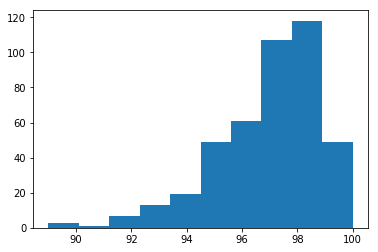

In [26]:
plt.hist(sleep_df['efficiency'])
plt.show()

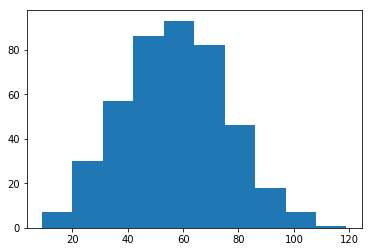

In [27]:
plt.hist(sleep_df['deep_minutes'])
plt.show()

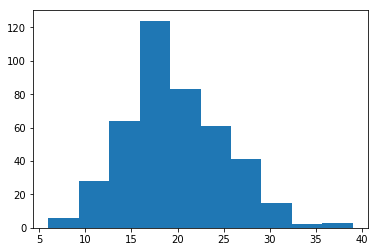

In [21]:
plt.hist(sleep_df['wake_count'])
plt.show()

In [22]:
sleep_df[sleep_df['efficiency'] < 92]

,bed_time,deep_count,deep_minutes,efficiency,end_date,light_count,light_minutes,minutes_asleep,rem_count,rem_minutes,start_date,wake_count,wake_minutes,wakeup_time
37,00:49:00,2,40,90,2018-06-15,15,271,391,7,80,2018-06-16,16,60,08:20:30
131,23:08:00,4,68,91,2018-03-19,25,243,424,7,113,2018-03-19,23,49,07:01:30
188,23:17:00,3,30,89,2018-01-23,19,283,382,5,69,2018-01-23,16,74,06:53:00
215,01:55:00,1,44,90,2017-12-29,14,267,386,3,75,2017-12-30,13,85,09:46:30


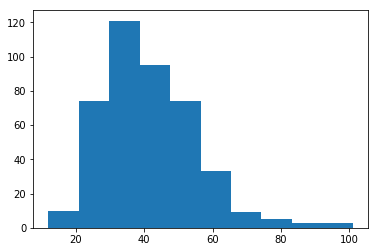

In [23]:
plt.hist(sleep_df['wake_minutes'])
plt.show()

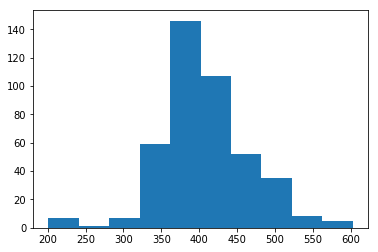

In [24]:
plt.hist(sleep_df['minutes_asleep'])
plt.show()

In [25]:
sleep_df['minutes_asleep'].mean()

407.37470725995314

# End Exploration of Sleep Endpoint data

For a deep exploration of specific data, please see the notebook in this repository: Fitbit Sleep Disruption Analysis

We've also included an appendix that contains preliminary investigation of other endpoints: Fitbit Data Analysis Appendix - Stray Investigations.